In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ambient_optimizer_python_api as aopa

In [2]:
train_data = pd.read_csv("../data/cr_20/csv/device_446_transportId_4.csv")

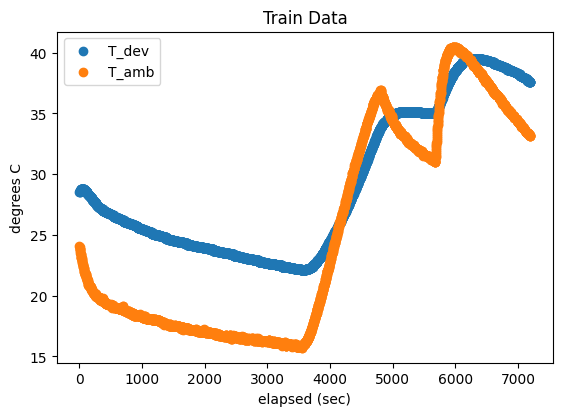

In [3]:
# Plot data

fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(111)
ax1.scatter(train_data['time'], train_data['Tdev'], label="T_dev")
ax1.scatter(train_data['time'], train_data['Tamb'], label="T_amb")
ax1.set_title("Train Data")
ax1.legend()
ax1.set_xlabel("elapsed (sec)")
ax1.set_ylabel("degrees C")
plt.show()

In [4]:
# Train model
aopa.init({
    "model": "train",
    "verbose": True
})
for t, T_dev in enumerate(train_data['Tdev']):
    T_amb = train_data['Tamb'][t]
    vect = [T_dev, T_amb]
    aopa.feed(t, vect)

fit_result = aopa.fit()

print(fit_result)

prediction_params = {
    'h': fit_result['fitted_params']['h'],
    'q': fit_result['fitted_params']['q']
}

{'is_valid': 1.0, 'rmse': 1.1670402127413542, 'icount': 241, 'ifault': 4, 'fitted_params': {'h': 0.0025279913539762292, 'q': 0.014512863756212465, 'T_dev_0': 27.7908194946169, 'T_amb_0': 0.0}}


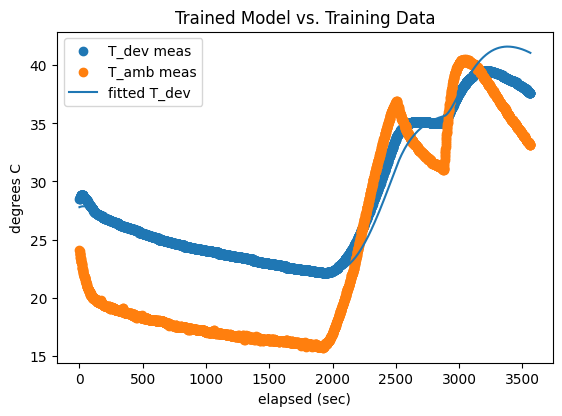

In [5]:
# Visualize trained model on training set
fitted_params = fit_result['fitted_params']
aopa.init({
    "model": "train",
    "verbose": True
})
for t, T_dev in enumerate(train_data['Tdev']):
    T_amb = train_data['Tamb'][t]
    aopa.feed(t, [-1, T_amb])
fitted_data = aopa.generate(fitted_params['h'], fitted_params['q'], fitted_params['T_dev_0'])

fitted_Tdev = fitted_data['x'][:, 0]

fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(111)
ax1.scatter(fitted_data['t'], train_data['Tdev'], label="T_dev meas")
ax1.scatter(fitted_data['t'], train_data['Tamb'], label="T_amb meas")
ax1.plot(fitted_data['t'], fitted_Tdev, label="fitted T_dev")
ax1.set_title("Trained Model vs. Training Data")
ax1.legend()
ax1.set_xlabel("elapsed (sec)")
ax1.set_ylabel("degrees C")
plt.show()

In [6]:
# Predict on training data
Tamb_predicted = []
prediction_window_size = 60
for ii in range(len(train_data['Tamb'])):
    if ii < prediction_window_size:
        Tamb_predicted.append(0)
    else:
        # print("Predicting on range: {}-{}".format(ii-prediction_window_size, ii))
        window = train_data.loc[ii-prediction_window_size:ii-1]

        aopa.init({
            "model": "predict",
            "verbose": False,
            "fixed_parameters": [prediction_params['h'], prediction_params['q']],
            "initial_guesses": [25]
        })
        for T_dev in window['Tdev']:
            aopa.feed(t, [T_dev])

        fit_result = aopa.fit()
        # print(fit_result)
        if fit_result['is_valid']:
            Tamb_predicted.append(fit_result['fitted_params']['T_amb_0'])
        else:
            Tamb_predicted.append(0)

        # break

# print(Tamb_predicted)

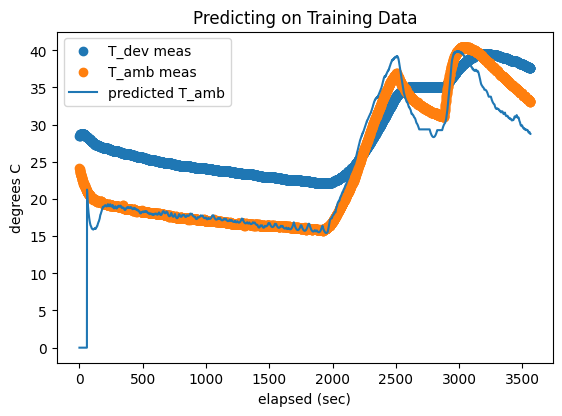

In [7]:

fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(111)
ax1.scatter(fitted_data['t'], train_data['Tdev'], label="T_dev meas")
ax1.scatter(fitted_data['t'], train_data['Tamb'], label="T_amb meas")
ax1.plot(fitted_data['t'], Tamb_predicted, label="predicted T_amb")
ax1.set_title("Predicting on Training Data")
ax1.legend()
ax1.set_xlabel("elapsed (sec)")
ax1.set_ylabel("degrees C")
plt.show()